<a href="https://colab.research.google.com/github/tanasrad/Machine-Learning-for-Finance/blob/master/R_code_Machine_Learning_in_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning For Finance - Chapter 1

Text from Klaas, J. (2019) - Machine Learning for Finance
Code from same source, translated into R (where possible)

## A logistic regressor

The simplest neural network is a logistic regressor. Logistic regression takes in values of any range but outputs only values between zero and one. There are many applications for logistic regressors. One example use case is to predict the likelihood of a homeowner to default on a mortgage. We might take all kinds of values into account to predict the likelihood of default, the debtor’s salary, whether she has a car, the security of her job, etc., but the likelihood will always be a value between zero and one. Even the worst debtor ever cannot have a default likelihood above 100% and the best cannot go below 0%.

To ensure we get the same result in all of our experiments, we have to set a random seed.

In [ ]:
set.seed(1)

Since our dataset is quite small, we define it manually as numpy matrices.

In [ ]:
X = matrix(c(0,1,0,1,0,0,1,1,1,0,1,1),nrow=4, byrow=TRUE)
print(X)
y = matrix(c(0,1,1,0),byrow=FALSE)
print(y)

     [,1] [,2] [,3]
[1,]    0    1    0
[2,]    1    0    0
[3,]    1    1    1
[4,]    0    1    1
     [,1]
[1,]    0
[2,]    1
[3,]    1
[4,]    0


To compute the output of the regressor, we must first do a linear step. We compute the dot product of the input X and the weights W. This is the same as multiplying each value of X with its weight and then taking the sum. To this number, we add the bias b. Afterwards, we do a nonlinear step. In the nonlinear step, we run the linear intermediate product z through an activation function, in this case, the sigmoid function. The sigmoid function squishes input values to outputs between zero and one.

We can define the sigmoid activation function as a function.

In [ ]:
sigmoid <- function(x) {
    1/(1+exp(-x))
}

So far, so good. Now we need to initialize W. In this case, we actually know already which values W should have. But we cannot know for other problems where we do not know the function yet. So, we have to assign weights randomly. The weights are usually assigned randomly with a mean of zero. The bias is usually set to zero by default. By default, the random values generated are between zero and one, with a mean of 0.5 and a standard deviation of 0.5. We want the random values to have a mean of 0 and a standard deviation of 1, so we first multiply the values generated by 2 and then subtract 1.

In [ ]:
W = 2*matrix(runif(3*1,0,1), nrow=3, ncol=1) - 1
b = 0
print(W); mean(W)

           [,1]
[1,]  0.8164156
[2,] -0.5966361
[3,]  0.7967794


[1] 0.3388529

Now that all variables are set, we can do the linear step:

In [ ]:
z = X%*%W + b; print(z)

           [,1]
[1,] -0.5966361
[2,]  0.8164156
[3,]  1.0165588
[4,]  0.2001432


And the nonlinear step:

In [ ]:
A = sigmoid(z)

If we print out A now, we get the following output:

In [ ]:
print(A)

          [,1]
[1,] 0.3551137
[2,] 0.6934749
[3,] 0.7343018
[4,] 0.5498694


This looks nothing like our desired output y at all! Clearly, our regressor is representing some function, but it is quite far away from the function we want. To better approximate our desired function, we have to tweak the weights W and the bias b to get better results.

In this case, our problem is a binary classification problem, so we will use the binary cross entropy loss:


$$
D_{BCE}(y,\hat{y}) = - 1/N \sum_{i=i}^{N}\left[y_i \log(\hat{y_i})+(1-y_i)\log(1-\hat{y_i})\right]
$$
Let's go through this step by step.


1.   $D_{BCE}(y,\hat{y})$ is the distance function for binary cross entropy loss.
2.   $-1/N \sum_{i=1}^{N}$ The loss over a batch of N examples is the average loss of all examples.
3.   $y_i*\log\hat{y}_i$ This part of the loss only comes into play if the true value, $y_i$ is 1, we want $\hat{y_i}$ to be as close to 1 as possible, to achieve a low loss.
4.   $(1-y_i)\log(1-\hat{y_i})$ This part of the loss comes into play if $y_i$ is 0. If so, we want $\hat{y_i}$ to be close to 0 as well. 

This loss function is implemented as follows:



In [ ]:
bce_loss <- function(y,y_hat) {
    N = nrow(y)
    -1/N * sum((y*log(y_hat) + (1-y)*log(1-y_hat)))
}

In [ ]:
bce_loss(y,A)

[1] 0.4779436

## Backpropagation

To update the parameters, we need to calculate the derivative of the loss function with respect to the weights and biases. If you imagine the parameters of our models like the geo coordinates in our mountain analogy, calculating the loss derivative with respect to a parameter is like checking the mountain slope in the direction north to see whether you should go north or south.

Note: to keep things simple, we refer to the derivative of the loss function to any variable as $d$variable. For example we write the derivative of the loss function with respect to the weights as $dW$.

To calculate the gradient with respect to different parameters of our model, we can make use of the chain rule. You might remember the chain rule as:

$$(f(g(x)))' = g(x)' * f'(g(x))$$
Sometimes also written as:$$\frac{dy}{dx} = \frac{dy}{du} \frac{du}{dx}$$

What the chain rule basically says is that if you want to take the derivative through a number of nested functions you multiply the derivative of the inner function with the derivative of the outer function. This is useful since neural networks, and our logistic regressor, are nested functions. The input goes through the linear step, a function of input, weights and biases. The output of the linear step, $z$ goes through the activation function.

So when we compute the loss derivative with respect to weights and bias, we first compute the loss derivative with respect to the output of the linear step $z$, and use it to compute the $dW$. In code it looks like this:

```
dz = (A - y)

dW = 1/N * t(X) %*% dz

db = 1/N * sum(dz,axis=0,keepdims=True)
```

## Parameter updates

Now we have the gradients, how do we improve our model? Or, to stay with our mountain analogy, now that we know that the mountain goes up in the North direction and up in the East direction, where do we go? To the South and to the West of course! Mathematically speaking, we go in the opposite direction than the gradient. If the gradient is positive with respect to a parameter, speak the slope is upward, we reduce the parameter. If it is negative, speak downward sloping, we increase it. When our slope is steeper, we move our gradient more.

The update rule for a parameter p then goes like:$$p = p - \alpha * dp$$

Where $p$ is a model parameter (either a weight or a bias), $dp$ is the loss derivative with respect to $p$ and $\alpha$ is the **learning rate**. The learning rate is something like the gas pedal in a car. It sets how much we want to apply the gradient updates. It is one of those hyper parameters that we have to set manually. We will discuss it in the next chapter.

In [ ]:
# Randomly initialize the weights
W <- 2*matrix(runif(3*1,0,1), nrow=3, ncol=1) - 1
b <- 0

# Set the learning rate alpha to 1
alpha <- 1

# We will train for 20 epochs
epochs <- 20

# Count the number of training examples we have (4)
N = nrow(y)

In the loop below we do multiple forward and backward passes and apply the gradient descent update rule.

In [ ]:
losses <- rep(NA,epochs) # Initialise an empty list for the loop (length of epochs)
for (i in 1:epochs) {
    # Do the linear step
    z <- X%*%W + b

    # Do the non linear step
    A <- sigmoid(z)

    # Calculate the loss
    loss <- bce_loss(y,A)

    # Keep track of the loss
    print(paste0("Epoch: ", i, " Loss: ", loss))
    losses <- append(losses,loss)

    # Back propagate
    dz <- (A-y)

    # ... calculate loss derivative with respect to weights
    dw <- 1/N * t(X) %*% dz

    # ... calculate loss derivative with respect to bias
    db <- 1/N * colSums(dz)

    # update parameters
    W <- W - alpha * dw
    b <- b - alpha * db
}

[1] "Epoch: 1 Loss: 0.177862079420977"
[1] "Epoch: 2 Loss: 0.17096394500881"
[1] "Epoch: 3 Loss: 0.16457854980946"
[1] "Epoch: 4 Loss: 0.158650900116939"
[1] "Epoch: 5 Loss: 0.153133568169585"
[1] "Epoch: 6 Loss: 0.147985442349833"
[1] "Epoch: 7 Loss: 0.143170714874616"
[1] "Epoch: 8 Loss: 0.138658056606617"
[1] "Epoch: 9 Loss: 0.134419940273474"
[1] "Epoch: 10 Loss: 0.130432082147659"
[1] "Epoch: 11 Loss: 0.126672978871157"
[1] "Epoch: 12 Loss: 0.123123521156851"
[1] "Epoch: 13 Loss: 0.11976666996469"
[1] "Epoch: 14 Loss: 0.116587183730277"
[1] "Epoch: 15 Loss: 0.113571387533718"
[1] "Epoch: 16 Loss: 0.110706976898496"
[1] "Epoch: 17 Loss: 0.107982850323846"
[1] "Epoch: 18 Loss: 0.105388965769451"
[1] "Epoch: 19 Loss: 0.102916217196136"
[1] "Epoch: 20 Loss: 0.100556327971927"


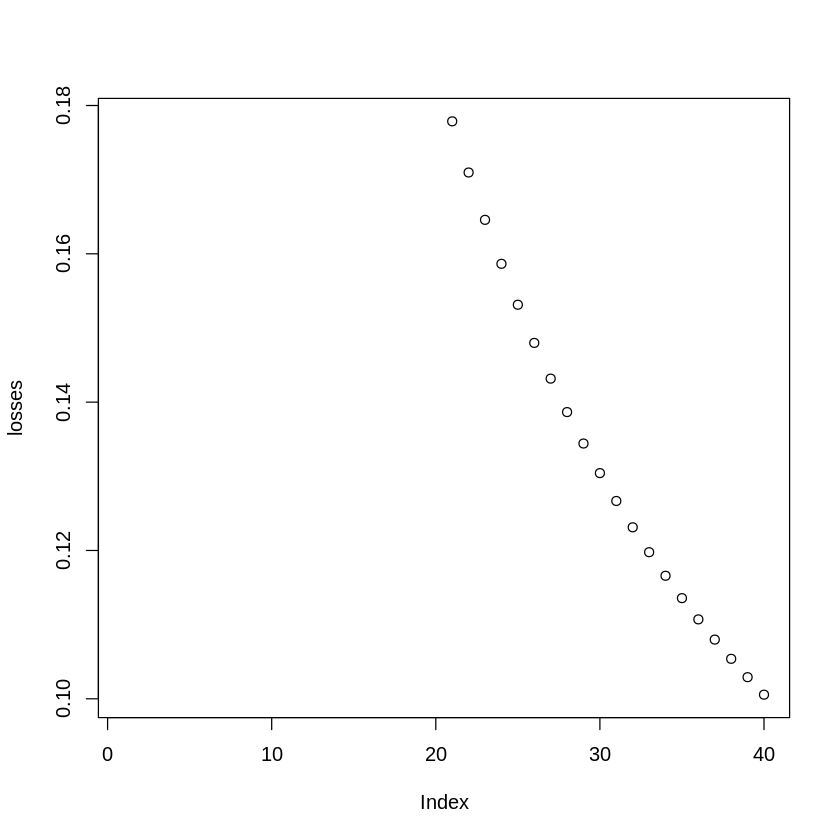

In [ ]:
plot(losses)

## A deeper network 
We established earlier that in order to approximate more complex functions, we need bigger, deeper networks. Creating a deeper networks works by stacking layers on top of each other.

In this section we will build a 2 layer neural network

The input gets multiplied with the first set of weights $W_1$, producing an intermediate product $z_1$ and then run through an activation function to produce the first layers activations $A_1$. These activations then get multiplied with a second layer of weights $W_2$, producing an intermediate product $z_2$ which gets run through a second activation function which produces the output $A_2$ of our neural net.

In [ ]:
sigmoid <- function(x) {
    # Calculates the sigmoid activation of a given input x
    # See: https://en.wikipedia.org/wiki/Sigmoid_function
    return(1/(1+exp(-x)))
}

bce_loss <- function(y,y_hat) {
    "
    Calculates the logistic loss between a prediction y_hat and the labels y
    See: http://wiki.fast.ai/index.php/Log_Loss

    We need to clip values that get too close to zero to avoid zeroing out. 
    Zeroing out is when a number gets so small that the computer replaces it with 0.
    Therefore, we clip numbers to a minimum value.
    "
    minval = 0.000000000001
    N = nrow(y)
    y_hat = clip(y_hat,.min=minval)
    return(-1/N * sum((y*log(y_hat) + (1-y)*log(1-y_hat))))
}

bce_loss_derivative <- function(y,y_hat) {
    "
    Calculates the gradient (derivative) of the log loss between point y and y_hat
    See: https://stats.stackexchange.com/questions/219241/gradient-for-logistic-loss-function
    "
    return(y_hat-y)
}

In [ ]:
install.packages("hash")
library(hash)

In [ ]:
forward_prop <- function(model,a0) {
"
Forward propagates through the model, stores results in cache.
    See: https://stats.stackexchange.com/questions/147954/neural-network-forward-propagation
    A0 is the activation at layer zero, it is the same as X
"
    # Load parameters from model
    W1 <- model['W1']
    b1 <- model['b1']
    W2 <- model['W2']
    b2 <- model['b2']

    # Linear step
    z1 = a0%*%W1 + b1

    # First activation function
    a1 = tanh(z1)
    
    # Second linear step
    z2 = a1%*%W2 + b2

    # Second activation function
    a2 = sigmoid(z2)

    cache <- hash()
    cache[['a0']] <- a0
    cache[['z1']] <- z1
    cache[['a1']] <- a1
    cache[['z2']] <- z2
    cache[['a2']] <- a2
    
    return(cache)
}

In [ ]:
tanh_derivative <- function(x) {
    "
    Calculates the derivative of the tanh function that is used as the first activation function
    See: https://socratic.org/questions/what-is-the-derivative-of-tanh-x
    "
    return(1 - power(x, 2))
}

In [ ]:
backward_prop <- function(model,cache,y) {
    "
    Backward propagates through the model to calculate gradients.
    Stores gradients in grads dictionary.
    See: https://en.wikipedia.org/wiki/Backpropagation
    "
    # Load parameters from model
    W1 <- model['W1']
    b1 <- model['b1']
    W2 <- model['W2']
    b2 <- model['b2']

    # Load forward propagation results
    a0 <- cache['a0']
    a1 <- cache['a1']
    a2 <- cache['a2']


    # Backpropagation
    # Calculate loss derivative with respect to output
    dz2 <- bce_loss_derivative(y=y,y_hat=a2)

    # Calculate loss derivative with respect to second layer weights
    dW2 <- t(a1)%*%dz2
    
    # Calculate loss derivative with respect to second layer bias
    db2 <- colSums(dz2[1])
    
    # Calculate loss derivative with respect to first layer
    dz1 <- dz2%*%t(W2) * tanh_derivative(a1)
    
    # Calculate loss derivative with respect to first layer weights
    dW1 <- t(a0)%*%dz1
    
    # Calculate loss derivative with respect to first layer bias
    db1 <- colSums(dz1[1])
    
    # Store gradients
    grads <- hash()
    grads[['dW2']] <- dW2
    grads[['db2']] <- db2
    grads[['dW1']] <- dW1
    grads[['db1']] <- db1

    return(grads)
}

Stopping here ... data set make_moons not available for R. 

## Keras
In this section we will build the same model with the Keras Sequential API. Code/Text from https://blog.rstudio.com/2017/09/05/keras-for-r/ written by JJ Allaire. 

In [ ]:
install.packages('keras', repos='http://cran.rstudio.com/')
library(keras)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Generate a dataset and plot it
set.seed(0)
mnist <- dataset_mnist()
x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y

To prepare the data for training we convert the 3-d arrays into matrices by reshaping width and height into a single dimension (28x28 images are flattened into length 784 vectors). Then, we convert the grayscale values from integers ranging between 0 to 255 into floating point values ranging between 0 and 1:

In [ ]:
# reshape
dim(x_train) <- c(nrow(x_train), 784)
dim(x_test) <- c(nrow(x_test), 784)
# rescale
x_train <- x_train / 255
x_test <- x_test / 255

The y data is an integer vector with values ranging from 0 to 9. To prepare this data for training we one-hot encode the vectors into binary class matrices using the Keras `to_categorical()` function:

In [ ]:
y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)

In [ ]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = "relu", input_shape = c(784)) %>% 
  layer_dropout(rate = 0.4) %>% 
  layer_dense(units = 128, activation = "relu") %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = "softmax")

The input_shape argument to the first layer specifies the shape of the input data (a length 784 numeric vector representing a grayscale image). The final layer outputs a length 10 numeric vector (probabilities for each digit) using a softmax activation function.

Use the `summary()` function to print the details of the model:

In [ ]:
summary(model)

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_5 (Dense)                     (None, 256)                     200960      
________________________________________________________________________________
dropout_3 (Dropout)                 (None, 256)                     0           
________________________________________________________________________________
dense_6 (Dense)                     (None, 128)                     32896       
________________________________________________________________________________
dropout_4 (Dropout)                 (None, 128)                     0           
________________________________________________________________________________
dense_7 (Dense)                     (None, 10)                      1290        
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_______________

Next, compile the model with appropriate loss function, optimizer, and metrics:

In [ ]:
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_rmsprop(),
  metrics = c("accuracy")
)

Use the fit() function to train the model for 30 epochs using batches of 128 images:

In [ ]:
history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2
)

The history object returned by `fit()` includes loss and accuracy metrics which we can plot:

`geom_smooth()` using formula 'y ~ x'



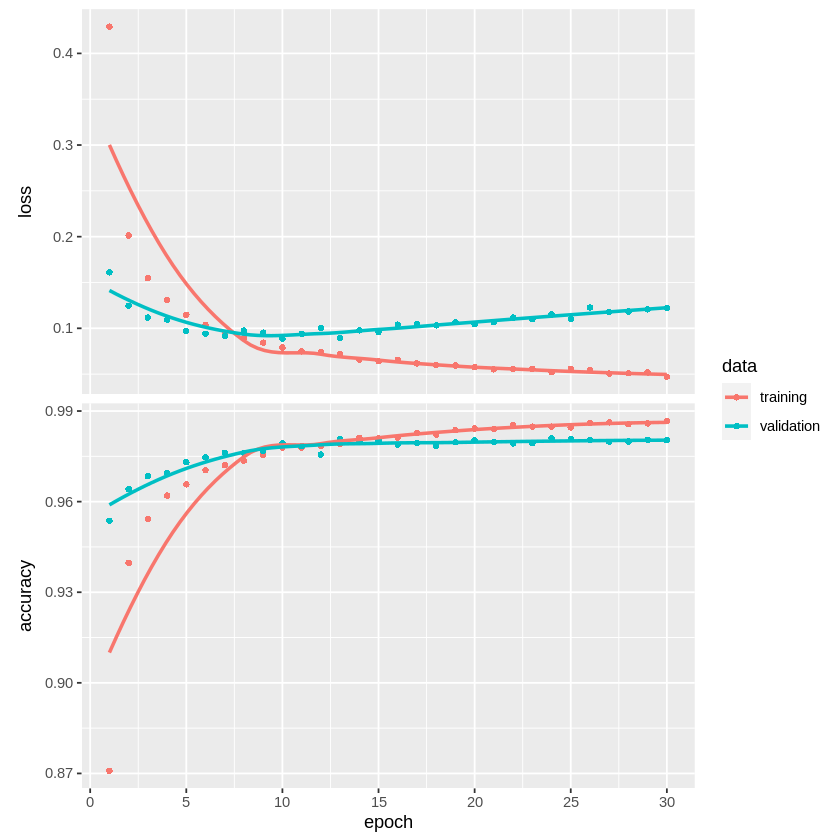

In [ ]:
plot(history)

Evaluate the model’s performance on the test data:

In [ ]:
model %>% evaluate(x_test, y_test,verbose = 0)

loss  accuracy 
0.1018035 0.9811000

Generate predictions on new data:

In [ ]:
model %>% predict_classes(x_test)

[1] 7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2
   [37] 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0
   [73] 2 9 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1
  [109] 9 4 8 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1
  [145] 7 1 8 2 0 2 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 7 1 8 1 8
  [181] 1 8 5 0 8 9 2 5 0 1 1 1 0 9 0 3 1 6 4 2 3 6 1 1 1 3 9 5 2 9 4 5 9 3 9 0
  [217] 3 6 5 5 7 2 2 7 1 2 8 4 1 7 3 3 8 8 7 9 2 2 4 1 5 9 8 7 2 3 0 2 4 2 4 1
  [253] 9 5 7 7 2 8 2 0 8 5 7 7 9 1 8 1 8 0 3 0 1 9 9 4 1 8 2 1 2 9 7 5 9 2 6 4
  [289] 1 5 8 2 9 2 0 4 0 0 2 8 4 7 1 2 4 0 2 7 4 3 3 0 0 3 1 9 6 5 2 5 8 7 9 3
  [325] 0 4 2 0 7 1 1 2 1 5 3 3 9 7 8 6 3 6 1 3 8 1 0 5 1 3 1 5 5 6 1 8 5 1 7 9
  [361] 4 6 2 2 5 0 6 5 6 3 7 2 0 8 8 5 4 1 1 4 0 3 3 7 6 1 6 2 1 9 2 8 6 1 9 5
  [397] 2 5 4 4 2 8 3 8 2 4 5 0 3 1 7 7 5 7 9 7 1 9 2 1 4 2 9 2 0 4 9 1 4 8 1 8
  [433] 4 5 9 8 8 3 7 6 0 0 3 0 2 0 6 4 9 3 3 3 2 3 9 1 2 6 8 0 5 6 6 6 3 8 8 2
  [469] 7 5 8 9 6 1 8 4 1 2 5 9 1 9 7 5 4 0 8 9 9 1 0 5 2 3 7 8 9 4 0 6 3 9 5 2
  [505] 1 3 1 3 6 5 7 4 2 2 6 3 2 6 5 4 8 9 7 1 3 0 3 8 3 1 9 3 4 4 6 4 2 1 8 2
  [541] 5 4 8 8 4 0 0 2 3 2 7 7 0 8 7 4 4 7 9 6 9 0 9 8 0 4 6 0 6 3 5 4 8 3 3 9
  [577] 3 3 3 7 8 0 2 8 1 7 0 6 5 4 3 8 0 9 6 3 8 0 9 9 6 8 6 8 5 7 8 6 0 2 4 0
  [613] 2 2 3 1 9 7 5 8 0 8 4 6 2 6 7 9 3 2 9 8 2 2 9 2 7 3 5 9 1 8 0 2 0 5 2 1
  [649] 3 7 6 7 1 2 5 8 0 3 7 2 4 0 9 1 8 6 7 7 4 3 4 9 1 9 5 1 7 3 9 7 6 9 1 3
  [685] 3 8 3 3 6 7 2 4 5 8 5 1 1 4 4 3 1 0 7 7 0 7 9 4 4 8 5 5 4 0 8 2 1 6 8 4
  [721] 8 0 4 0 6 1 7 3 2 6 7 2 6 9 3 1 4 6 2 5 9 2 0 6 2 1 7 3 4 1 0 5 4 3 1 1
  [757] 7 4 9 9 4 8 4 0 2 4 5 1 1 6 4 7 1 9 4 2 4 1 5 5 3 8 3 1 4 5 6 8 9 4 1 5
  [793] 3 8 0 3 2 5 1 2 8 3 4 4 0 8 8 3 3 1 2 3 5 9 6 3 2 6 1 3 6 0 7 2 1 7 1 4
  [829] 2 4 2 1 7 9 6 1 1 2 4 8 1 7 7 4 8 0 7 3 1 3 1 0 7 7 0 3 5 5 2 7 6 6 9 2
  [865] 8 3 5 2 2 5 6 0 8 2 9 2 8 8 8 8 7 4 9 5 0 6 6 3 2 1 3 2 2 9 3 0 0 5 7 8
  [901] 3 4 4 6 0 2 9 1 4 7 4 7 3 9 8 8 4 7 1 2 1 2 2 3 2 3 2 3 9 1 7 4 0 3 5 5
  [937] 8 6 3 2 6 7 6 6 3 2 7 8 1 1 7 5 6 4 9 5 2 3 3 4 7 8 9 1 1 0 9 1 4 4 5 4
  [973] 0 6 2 2 3 1 5 1 2 0 3 8 1 2 6 7 1 6 2 3 9 0 1 2 2 0 8 9 9 0 2 5 1 9 7 8
 [1009] 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 2 1 5 3 4
 [1045] 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9 2 2 3 3 8 3 5 7 3 5 8 1 2 4 4 6
 [1081] 4 9 5 1 0 6 9 5 9 5 9 7 3 8 0 3 7 1 3 6 7 2 5 9 7 9 6 9 6 3 7 4 6 5 3 5
 [1117] 4 7 8 7 8 0 7 6 8 8 7 3 3 1 9 5 2 7 3 5 1 1 2 1 4 7 4 7 5 4 5 4 0 8 3 6
 [1153] 9 6 0 2 7 4 4 4 4 6 6 4 7 9 3 4 5 5 8 7 3 7 2 7 0 2 4 1 1 6 8 9 2 8 7 2
 [1189] 0 1 5 0 9 1 7 0 6 0 8 6 8 1 8 0 3 3 7 2 3 6 2 1 6 1 1 3 7 9 0 8 0 5 4 0
 [1225] 2 8 2 2 3 8 4 0 9 5 8 5 1 2 1 3 1 7 9 5 7 2 0 5 8 8 6 2 5 4 1 9 2 1 5 8
 [1261] 7 0 2 4 4 3 6 8 8 2 4 0 5 0 4 4 7 9 3 4 1 5 9 7 3 5 8 8 0 5 3 3 6 6 0 1
 [1297] 6 0 3 5 4 4 1 2 9 1 4 6 9 9 3 9 8 4 4 3 1 3 1 0 8 7 9 4 8 8 7 9 8 1 4 5
 [1333] 6 0 5 2 2 2 1 5 5 2 4 9 6 2 7 7 2 2 1 1 2 8 3 7 2 4 1 7 1 7 6 7 8 2 7 3
 [1369] 1 7 5 8 2 6 2 2 5 6 5 0 9 2 4 3 3 9 7 6 6 8 0 4 1 3 8 2 9 1 8 0 6 7 2 1
 [1405] 0 5 5 2 0 2 2 0 2 4 7 8 0 9 9 4 6 5 4 9 1 8 3 4 9 9 1 2 2 8 1 9 6 4 0 9
 [1441] 4 8 3 8 6 0 2 5 1 9 6 2 9 4 0 9 6 0 6 2 5 4 2 3 8 4 5 5 0 3 8 5 3 5 8 6
 [1477] 5 7 6 3 3 9 6 1 1 2 9 0 4 3 3 6 9 5 7 3 7 7 7 8 3 9 8 3 0 7 2 7 9 4 5 4
 [1513] 9 3 2 1 4 0 2 3 7 5 9 8 8 5 0 1 1 4 7 3 9 0 0 0 6 6 2 3 7 8 4 7 7 9 2 4
 [1549] 1 6 5 2 4 3 8 1 8 4 0 9 8 4 8 7 7 0 7 8 8 4 0 4 8 8 2 4 7 6 6 6 4 7 1 8
 [1585] 8 2 3 6 3 0 0 3 7 6 9 7 9 9 5 4 3 3 6 1 2 3 7 3 3 2 0 3 3 8 4 3 6 3 5 0
 [1621] 2 6 9 0 7 4 6 9 3 5 1 9 6 1 4 5 4 5 0 5 9 5 2 1 2 9 1 9 9 4 0 8 4 5 2 9
 [1657] 2 1 2 1 7 3 6 8 8 4 9 1 9 8 5 7 5 1 1 8 6 5 2 4 4 7 2 3 5 6 8 8 6 2 3 1
 [1693] 0 5 8 9 2 9 6 7 0 4 8 7 1 7 4 1 0 9 7 2 0 0 9 1 7 0 7 8 4 7 2 0 4 6 0 3
 [1729] 1 1 3 3 3 6 7 4 1 5 3 0 8 7 3 9 6 9 3 5 0 2 7 2 5 1 2 5 8 0 8 8 1 5 0 3
 [1765] 0 3 1 4 0 3 7 2 7 1 8 0 7 0 4 3 1 9 8 7 7 1 4 9 9 3 8 1 7 9 0 2 0 3 3 7
 [18

Keras provides a vocabulary for building deep learning models that is simple, elegant, and intuitive. 